**NOTES**: <br>

1. Data-leak issue has been overlooked uptil feature importance selection. In model building, it has been duly taken care of. <br/>
2. It's worth experimenting with regression analysis by considering features related to future stock returns (like monthvwretd, monthvwretx, roa, roe, gpm, npm, etc. as targets) But it has not been done here due to time constraints. 

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, mean_squared_error, r2_score
from sklearn.model_selection import StratifiedKFold, KFold

from ydata_profiling import ProfileReport

from mord import OrdinalRidge

import os
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pathlib import Path
import nltk

from dotenv import load_dotenv
load_dotenv()

pd.set_option('display.max_columns', None)

# $A.$ Data Exploration & Cleaning:

## $A.1$ Load & Inspect the Data:

In [173]:
df = pd.read_excel("./data/Artificial_Data.xlsx")
df.head()

,RATING_TYPE,Rating,FundaIndxint,FundaIndxsga,monthvwretd,monthvwretx,monthewretd,monthewretx,monthsprtrn,monthspindx,monthCAP1RET,monthCAP2RET,monthCAP3RET,monthCAP4RET,monthCAP5RET,monthCAP6RET,monthCAP7RET,monthCAP8RET,monthCAP9RET,monthCAP10RET,monthtotval,monthtotcnt,monthusdval,monthusdcnt,monthprtcnt,monthtotret,monthtotind,monthcapret,monthcapind,monthincret,monthincind,SPIndvwretd,SPIndvwretx,SPIndewretd,SPIndewretx,SPIndtotval,SPIndtotcnt,SPIndusdval,SPIndusdcnt,SPIndspindx,SPIndsprtrn,SPporvwretd,SPporvwretx,SPporewretd,SPporewretx,SPportotval,SPportotcnt,SPporusdval,SPporusdcnt,SPporspindx,SPporsprtrn,usind2CRSPMEV1,usind2CRSPMEG1,usind2CRSPLCV1,usind2CRSPLCG1,usind2CRSPMIV1,usind2CRSPMIG1,usind2CRSPSCV1,usind2CRSPSCG1,usind2CRSPMEVT,usind2CRSPMEGT,usind2CRSPLCVT,usind2CRSPLCGT,usind2CRSPMIVT,usind2CRSPMIGT,usind2CRSPSCVT,usind2CRSPSCGT,stockvwretd,stockvwretx,stockvwTotVal,stockvwUsdVal,stockvwTotCnt,stockvwUsdCnt,stockewretd,stockewretx,stockewTotVal,stockewUsdVal,stockewTotCnt,stockewUsdCnt,stocksprtrn,ustreb30ret,ustreb30ind,ustreb20ret,ustreb20ind,ustreb10ret,ustreb10ind,ustreb7ret,ustreb7ind,ustreb5ret,ustreb5ind,ustreb2ret,ustreb2ind,ustreb1ret,ustreb1ind,ustret90ret,ustret90ind,ustret30ret,ustret30ind,ustrecpiret,ajexm,ajpm,cshtrm,prccm,prchm,prclm,trfm,trt1m,index_y,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,aftret_eq,aftret_invcapx,aftret_equity,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,cash_lt,debt_at,debt_ebitda,lt_debt,cash_debt,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,rd_sale,adv_sale,staff_sale,accrual,string_values
0,Fitch,A+,0.150659,-0.420047,-0.846934,0.560226,0.579303,-0.578314,-0.225006,-0.415867,-1.215753,-0.476301,0.874834,-1.022435,-0.592828,-1.241319,0.693856,2.543668,-0.063223,-0.078271,1.425937,-0.286392,0.107695,0.368484,0.473373,0.396630,1.044191,-0.669476,-0.111602,1.130983,1.152031,0.302311,-0.736802,-0.443736,0.272516,0.404059,0.915985,1.851882,0.908960,0.000710,-0.694966,-0.975380,1.141629,1.958655,2.063247,-2.144040,0.160316,0.397852,2.138209,0.053541,-1.229052,-1.113458,-1.009830,-1.038158,0.039339,-1.235293,-0.782989,0.149919,1.493474,0.120604,-0.762732,-0.353671,-0.984878,0.230495,-0.126560,-0.498726,1.457921,-0.809059,-0.462191,-0.536018,0.402635,2.038329,-0.121149,-0.706920,-0.504695,0.706406,1.093690,-0.820577,-0.542499,-1.055582,-1.057493,-0.586529,0.186066,0.099920,-1.616170,1.050058,-0.052598,-0.762544,1.825537,0.127429,0.770730,0.273964,1.337434,1.305522,1.689208,-0.359044,0.807806,-0.978221,-1.720015,-0.874147,-0.525495,-0.860300,0.627591,-0.286398,0.467699,-1.147011,-0.521327,-0.070616,-1.401960,0.713078,-0.205677,-0.282390,1.178308,1.003396,-0.533333,0.139489,0.923675,-0.488365,-0.515819,0.310693,-0.608079,-0.678698,1.288532,-1.752647,-1.061738,-1.036068,-0.408694,0.652038,-0.440448,0.546817,-0.109775,1.059235,0.026479,1.865921,-0.569945,2.178375,0.233034,-1.005129,-0.168922,0.480367,-0.373437,0.132425,-0.716007,-0.747744,-0.810215,0.308114,-0.596329,-0.235425,-0.456676,1.878286,-1.338060,0.862565,0.822648,"Challenges remain in the supply chain, but str..."
1,Moody's,BB,-0.015715,0.139204,-0.045250,-0.912128,0.497292,-0.910558,1.207592,-0.104050,0.154247,1.388313,-2.156981,2.079946,-0.507333,0.605540,-0.102836,0.182807,-1.521528,-0.345610,1.308224,0.327420,0.411786,-0.179510,1.335656,-1.313861,3.121897,0.275221,-0.771017,0.750278,1.822169,0.752827,-0.366732,1.194922,-1.859780,-1.346370,0.749366,-0.281068,0.459390,-0.175449,-0.027828,0.936036,-0.442155,0.143769,0.299055,0.175620,1.728682,1.016630,1.318105,0.971610,1.123097,1.522147,0.574736,0.645630,1.393169,0.041978,2.097410,0.120120,2.118975,-0.093658,1.386308,-0.014961,-0.249286,-0.502040,0.955377,-0.669921,0.902108,-1.838453,-1.598496,1.559406,-0.474998,-0.533301,1.438526,1.271909,0.127735,-1.275876,3.093430,1.318330,1.536686,0.966820,-0.188672,-0.004129,1.079702,0.498467,-1.262321,0

In [8]:
df.describe()

,FundaIndxint,FundaIndxsga,monthvwretd,monthvwretx,monthewretd,monthewretx,monthsprtrn,monthspindx,monthCAP1RET,monthCAP2RET,monthCAP3RET,monthCAP4RET,monthCAP5RET,monthCAP6RET,monthCAP7RET,monthCAP8RET,monthCAP9RET,monthCAP10RET,monthtotval,monthtotcnt,monthusdval,monthusdcnt,monthprtcnt,monthtotret,monthtotind,monthcapret,monthcapind,monthincret,monthincind,SPIndvwretd,SPIndvwretx,SPIndewretd,SPIndewretx,SPIndtotval,SPIndtotcnt,SPIndusdval,SPIndusdcnt,SPIndspindx,SPIndsprtrn,SPporvwretd,SPporvwretx,SPporewretd,SPporewretx,SPportotval,SPportotcnt,SPporusdval,SPporusdcnt,SPporspindx,SPporsprtrn,usind2CRSPMEV1,usind2CRSPMEG1,usind2CRSPLCV1,usind2CRSPLCG1,usind2CRSPMIV1,usind2CRSPMIG1,usind2CRSPSCV1,usind2CRSPSCG1,usind2CRSPMEVT,usind2CRSPMEGT,usind2CRSPLCVT,usind2CRSPLCGT,usind2CRSPMIVT,usind2CRSPMIGT,usind2CRSPSCVT,usind2CRSPSCGT,stockvwretd,stockvwretx,stockvwTotVal,stockvwUsdVal,stockvwTotCnt,stockvwUsdCnt,stockewretd,stockewretx,stockewTotVal,stockewUsdVal,stockewTotCnt,stockewUsdCnt,stocksprtrn,ustreb30ret,ustreb30ind,ustreb20ret,ustreb20ind,ustreb10ret,ustreb10ind,ustreb7ret,ustreb7ind,ustreb5ret,ustreb5ind,ustreb2ret,ustreb2ind,ustreb1ret,ustreb1ind,ustret90ret,ustret90ind,ustret30ret,ustret30ind,ustrecpiret,ajexm,ajpm,cshtrm,prccm,prchm,prclm,trfm,trt1m,index_y,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,aftret_eq,aftret_invcapx,aftret_equity,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,cash_lt,debt_at,debt_ebitda,lt_debt,cash_debt,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,rd_sale,adv_sale,staff_sale,accrual
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.067201,0.075317,0.010728,0.127477,0.093248,0.032180,-0.026623,0.107747,0.166456,-0.016642,0.004519,-0.171137,-0.095426,0.062415,0.003817,0.126753,-0.057736,0.096029,0.092430,0.175558,0.021667,-0.065542,0.222348,0.088733,0.140732,0.001310,0.117590,-0.034283,-0.089963,-0.113169,-0.018462,-0.101635,-0.097956,-0.002270,0.145488,0.042009,0.087021,0.173191,-0.133281,-0.057548,0.049705,-0.072587,0.228524,-0.209634,-0.141104,-0.023233,-0.067106,-0.147392,0.134264,0.062642,0.034880,0.001169,0.101759,-0.101938,-0.051918,-0.054720,0.121034,0.003347,0.142587,0.123700,-0.041919,0.006466,0.089559,-0.006919,-0.031315,-0.114387,0.131229,-0.113806,0.024481,0.1556

In [13]:
profile = ProfileReport(df, explorative=True)
profile.to_file("./reports/EDA_Report.html")

Summarize dataset: 100%|█████████▉| 22961/22964 [43:15<00:01,  2.76it/s, Detecting duplicates]                  c:\D\miniconda\envs\general-nlp\lib\site-packages\ydata_profiling\model\pandas\duplicates_pandas.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[duplicated_rows]
c:\D\miniconda\envs\general-nlp\lib\site-packages\ydata_profiling\model\pandas\duplicates_pandas.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[duplicated_rows]
c:\D\miniconda\envs\general-nlp\lib\site-packages\ydata_profiling\model\pandas\dup

In [14]:

profile = ProfileReport(df, minimal=True)
profile.to_file("./reports/EDA_Report_minimal.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 27.75it/s]


In [9]:
df[df['Rating']=='bbb']

,RATING_TYPE,Rating,FundaIndxint,FundaIndxsga,monthvwretd,monthvwretx,monthewretd,monthewretx,monthsprtrn,monthspindx,monthCAP1RET,monthCAP2RET,monthCAP3RET,monthCAP4RET,monthCAP5RET,monthCAP6RET,monthCAP7RET,monthCAP8RET,monthCAP9RET,monthCAP10RET,monthtotval,monthtotcnt,monthusdval,monthusdcnt,monthprtcnt,monthtotret,monthtotind,monthcapret,monthcapind,monthincret,monthincind,SPIndvwretd,SPIndvwretx,SPIndewretd,SPIndewretx,SPIndtotval,SPIndtotcnt,SPIndusdval,SPIndusdcnt,SPIndspindx,SPIndsprtrn,SPporvwretd,SPporvwretx,SPporewretd,SPporewretx,SPportotval,SPportotcnt,SPporusdval,SPporusdcnt,SPporspindx,SPporsprtrn,usind2CRSPMEV1,usind2CRSPMEG1,usind2CRSPLCV1,usind2CRSPLCG1,usind2CRSPMIV1,usind2CRSPMIG1,usind2CRSPSCV1,usind2CRSPSCG1,usind2CRSPMEVT,usind2CRSPMEGT,usind2CRSPLCVT,usind2CRSPLCGT,usind2CRSPMIVT,usind2CRSPMIGT,usind2CRSPSCVT,usind2CRSPSCGT,stockvwretd,stockvwretx,stockvwTotVal,stockvwUsdVal,stockvwTotCnt,stockvwUsdCnt,stockewretd,stockewretx,stockewTotVal,stockewUsdVal,stockewTotCnt,stockewUsdCnt,stocksprtrn,ustreb30ret,ustreb30ind,ustreb20ret,ustreb20ind,ustreb10ret,ustreb10ind,ustreb7ret,ustreb7ind,ustreb5ret,ustreb5ind,ustreb2ret,ustreb2ind,ustreb1ret,ustreb1ind,ustret90ret,ustret90ind,ustret30ret,ustret30ind,ustrecpiret,ajexm,ajpm,cshtrm,prccm,prchm,prclm,trfm,trt1m,index_y,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,aftret_eq,aftret_invcapx,aftret_equity,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,cash_lt,debt_at,debt_ebitda,lt_debt,cash_debt,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,rd_sale,adv_sale,staff_sale,accrual,string_values


In [12]:

profile = ProfileReport(df[df['Rating']=='BBB+'], minimal=True)
profile.to_file("./reports/EDA_Report_minimal_bbbp.html")

profile = ProfileReport(df[df['Rating']=='BBB'], minimal=True)
profile.to_file("./reports/EDA_Report_minimal_bbb.html")

profile = ProfileReport(df[df['Rating']=='BB'], minimal=True)
profile.to_file("./reports/EDA_Report_minimal_bb.html")

profile = ProfileReport(df[df['Rating']=='AAA'], minimal=True)
profile.to_file("./reports/EDA_Report_minimal_aaa.html")

profile = ProfileReport(df[df['Rating']=='AA+'], minimal=True)
profile.to_file("./reports/EDA_Report_minimal_aap.html")

profile = ProfileReport(df[df['Rating']=='AA'], minimal=True)
profile.to_file("./reports/EDA_Report_minimal_aa.html")

profile = ProfileReport(df[df['Rating']=='A+'], minimal=True)
profile.to_file("./reports/EDA_Report_minimal_ap.html")

profile = ProfileReport(df[df['Rating']=='A'], minimal=True)
profile.to_file("./reports/EDA_Report_minimal_a.html")

c:\D\miniconda\envs\ydata-profiling\Lib\site-packages\ydata_profiling\utils\dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 20.63it/s]
c:\D\miniconda\envs\ydata-profiling\Lib\site-packages\ydata_profiling\utils\dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 21.01it/s]
c:\D\miniconda\envs\ydata-profiling\Lib\site-packages\ydata_profiling\utils\dataframe.py:137: Sett

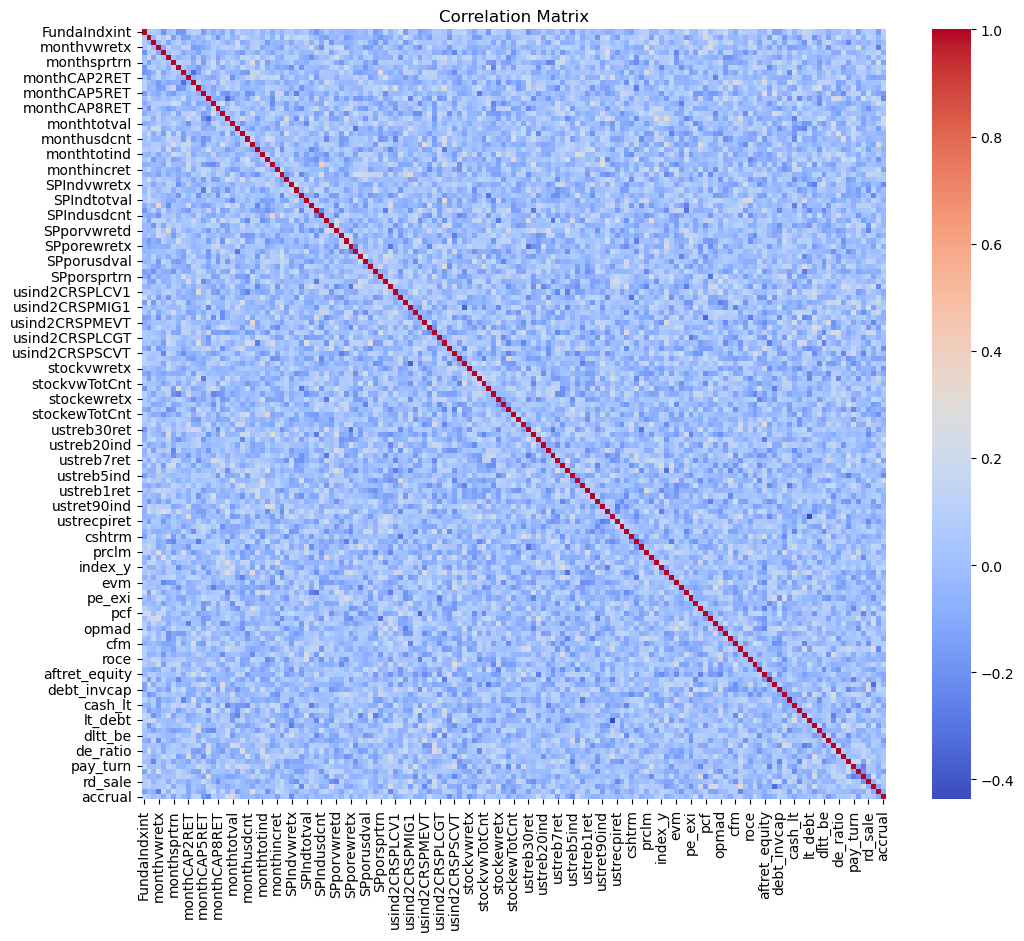

In [234]:
corr_matrix = df.iloc[:, 2:-1].corr(method='pearson')

# Visualize 
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation Matrix")
plt.show()

Following are the observations from the stats reports: <br>
1. 
2. 
3. 

## $A.2$ Preprocessing:

We're going to experiment with the following models for both structure-only model, text-only model and combined model: <br/>
1. Classification model: Random Forest considering rating as target classes. <br/>
2. Ordinal model (Ordinal Regression): Ridge Ordinal Regression considering rating as ordinals. <br/>
<br/>
For 2nd model, we'll encode the target ordinally. <br>

In [ ]:
df.shape

(100, 154)


Since the number of features are more than the number of data points, we'd reduce the number of features in order to avoid overfitting. <br>

In [266]:
# Separate features and target
X_rf = df.drop(['Rating', 'string_values'], axis=1)
y = df['Rating']

# Encode categorical variables
#label_encoder = LabelEncoder()
#X_rf['RATING_TYPE'] = label_encoder.fit_transform(X_rf['RATING_TYPE'])
X_rf['RATING_TYPE'] = X_rf['RATING_TYPE'].astype('category').cat.codes

# Perform standardization
X_rf = (X_rf - X_rf.mean()) / X_rf.std()

We are gonna try out different feature reduction strategies and gauge their reliability by calculating **IoU** of the features selected in different iterations.

In [ ]:
TOP_N_FEATURES = 50
NO_ITERATIONS = 6

# Function to calculate IoU
def calculate_iou(feature_sets):
    iou_scores = []
    for i in range(len(feature_sets)):
        for j in range(i + 1, len(feature_sets)):
            intersection = len(set(feature_sets[i]).intersection(set(feature_sets[j])))
            union = len(set(feature_sets[i]).union(set(feature_sets[j])))
            iou_scores.append(intersection / union)
    return np.mean(iou_scores)

# ---------- Experiment with Different Feature Importance Strategies ----------
strategies = {
    "Random Forest": [],
    "Mutual Info": [],
    "SelectKBest (Anova)": [],
    "Permutation Importance": [],
    "SHAP Values": []
}

for i in range(NO_ITERATIONS):
    print(f"\nIteration {i+1}")
    
    # ---------- Random Forest Importance ----------
    model = RandomForestClassifier(max_features=None)
    model.fit(X_rf, y)
    train_accuracy = accuracy_score(y, model.predict(X_rf))
    print(f"Training Accuracy (RF): {train_accuracy}")
    
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)[::-1][:TOP_N_FEATURES]
    strategies["Random Forest"].append(X_rf.columns[sorted_idx])

    # ---------- Mutual Information ----------
    mi_scores = mutual_info_classif(X_rf, y)
    sorted_idx = np.argsort(mi_scores)[::-1][:TOP_N_FEATURES]
    strategies["Mutual Info"].append(X_rf.columns[sorted_idx])

    # ---------- SelectKBest with Anova ----------
    kbest = SelectKBest(score_func=f_classif, k=TOP_N_FEATURES)
    kbest.fit_transform(X_rf, y)
    sorted_idx = np.argsort(kbest.scores_)[::-1][:TOP_N_FEATURES]
    strategies["SelectKBest (Anova)"].append(X_rf.columns[sorted_idx])

    # ---------- Permutation Importance ----------
    perm_importance = permutation_importance(model, X_rf, y, n_repeats=10)
    sorted_idx = np.argsort(perm_importance.importances_mean)[::-1][:TOP_N_FEATURES]
    strategies["Permutation Importance"].append(X_rf.columns[sorted_idx])


# ---------- Calculate IoU for Each Strategy ----------
for strategy, feature_sets in strategies.items():
    iou_score = calculate_iou(feature_sets)
    print(f"\nIoU for {strategy}: {iou_score:.2f}")



Iteration 1
Training Accuracy (RF): 1.0

Iteration 2
Training Accuracy (RF): 1.0

Iteration 3
Training Accuracy (RF): 1.0

Iteration 4
Training Accuracy (RF): 1.0

Iteration 5
Training Accuracy (RF): 1.0

Iteration 6
Training Accuracy (RF): 1.0

IoU for Random Forest: 0.50

IoU for Mutual Info: 0.99

IoU for SelectKBest (Anova): 1.00

IoU for Permutation Importance: 1.00

IoU for SHAP Values: nan


c:\D\miniconda\envs\ydata-profiling\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\D\miniconda\envs\ydata-profiling\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [241]:
print (strategies['SelectKBest (Anova)'][0])
print (strategies['Permutation Importance'][0])
print (strategies['Mutual Info'][0])

Index(['SPIndsprtrn', 'usind2CRSPMEV1', 'ustreb30ret', 'SPporvwretx',
       'usind2CRSPLCVT', 'monthCAP7RET', 'usind2CRSPLCV1', 'roa',
       'SPIndusdcnt', 'ustreb10ind', 'monthtotval', 'ustret30ind',
       'debt_ebitda', 'pe_exi', 'usind2CRSPSCVT', 'stockewretd',
       'totdebt_invcap', 'monthusdcnt', 'pcf', 'ustreb7ret'],
      dtype='object')
Index(['accrual', 'staff_sale', 'adv_sale', 'rd_sale', 'sale_equity',
       'sale_invcap', 'pay_turn', 'rect_turn', 'at_turn', 'de_ratio',
       'debt_capital', 'debt_assets', 'dltt_be', 'lt_ppent', 'cash_debt',
       'lt_debt', 'debt_ebitda', 'debt_at', 'cash_lt', 'capital_ratio'],
      dtype='object')
Index(['monthewretd', 'ustreb1ret', 'roa', 'roce', 'SPIndsprtrn',
       'stockewTotVal', 'ustret30ind', 'monthvwretd', 'ustreb30ind',
       'ustret90ret', 'SPporvwretx', 'pe_inc', 'usind2CRSPSCG1', 'ustreb30ret',
       'SPIndvwretx', 'SPIndtotcnt', 'usind2CRSPMIG1', 'monthspindx',
       'usind2CRSPSCGT', 'monthCAP8RET'],
      dtype=

**Observations:** <br/>
1. Except Random Forest, all the strategies are finding same features in every iterations. It suggests that Random forest features selection is unreliable. <br/>
2. Even for the reliable strategies, they are not coming up with the same set of important features. 

In [246]:
set(strategies['SelectKBest (Anova)'][0]).intersection(set(strategies['Mutual Info'][0])).intersection(set(strategies['Permutation Importance'][0]))

{'de_ratio', 'debt_ebitda', 'roa', 'totdebt_invcap'}

In [ ]:

feature_sets = strategies["Mutual Info"] + strategies["SelectKBest (Anova)"] + strategies["Permutation Importance"]
flattened_features = [feature for sublist in feature_sets for feature in sublist]
NO_ITERATIONS = 6
# Count feature occurrences
feature_counts = Counter(flattened_features)
print(feature_counts)
# Select features selected by at least 2 methods
consensus_features = [k for k, v in feature_counts.items() if v >= 2*NO_ITERATIONS]
print(f"Consensus Features ({len(consensus_features)}):", consensus_features)


Counter({'roa': 18, 'totdebt_invcap': 18, 'de_ratio': 18, 'debt_ebitda': 18, 'monthewretd': 12, 'ustreb1ret': 12, 'roce': 12, 'SPIndsprtrn': 12, 'ustret30ind': 12, 'monthvwretd': 12, 'SPporvwretx': 12, 'pe_inc': 12, 'ustreb30ret': 12, 'usind2CRSPMIG1': 12, 'monthCAP8RET': 12, 'monthincret': 12, 'SPIndusdval': 12, 'stockvwretx': 12, 'usind2CRSPMEV1': 12, 'ustreb7ret': 12, 'cash_debt': 12, 'ptpm': 12, 'equity_invcap': 12, 'lt_debt': 12, 'stockvwretd': 12, 'evm': 12, 'monthCAP2RET': 12, 'stockewretd': 12, 'ps': 12, 'monthtotind': 12, 'SPIndusdcnt': 12, 'pe_exi': 12, 'pcf': 12, 'pe_op_dil': 12, 'prclm': 12, 'pe_op_basic': 12, 'rect_turn': 12, 'staff_sale': 12, 'opmad': 12, 'accrual': 11, 'stockewTotVal': 6, 'ustreb30ind': 6, 'ustret90ret': 6, 'usind2CRSPSCG1': 6, 'SPIndvwretx': 6, 'SPIndtotcnt': 6, 'monthspindx': 6, 'usind2CRSPSCGT': 6, 'usind2CRSPMIVT': 6, 'cshtrm': 6, 'ustreb5ind': 6, 'SPIndewretx': 6, 'monthtotret': 6, 'SPporewretd': 6, 'ustreb10ret': 6, 'monthCAP3RET': 6, 'ustreb20ret'

# $B.$ NLP Feature Engineering:

## $B.1$ Text Preprocessing:

Although it's not required as the textual data is limited (it has only 5 different scenarios that can be dealt as categories), in case of larger variety the following can be used to perform preprocessing.

In [ ]:
# Clean the string_values column: remove punctuation, lowercasing, stopword removal, and optional stemming or lemmatization.


# Download necessary NLTK resources
nltk.download('punkt', download_dir=os.environ["NLTK_DATA"])
nltk.download('stopwords', download_dir=os.environ["NLTK_DATA"])
nltk.data.path.append(os.path.join(os.getcwd(), Path(os.environ['NLTK_DATA'])))

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

ENGLISH_STOP_WORDS = set(stopwords.words('english'))

# Cleaning function
def clean_text(text):
    # Lowercasing
    text = text.lower()
    # Remove punctuation using regex
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in ENGLISH_STOP_WORDS]
    return ' '.join(cleaned_tokens)

df['cleaned_string_values'] = df['string_values'].apply(clean_text)

print(df[['string_values', 'cleaned_string_values']])


## $B.2$ Text Representation:

In [2]:
import torch
from transformers import AutoTokenizer, AutoModel

# Load BERT tokenizer and model
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Convert text to embeddings
def get_embeddings(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        # Extract CLS token embeddings (first token)
        embeddings = outputs.last_hidden_state[:, 0, :]
    return embeddings.numpy()

# Example
embeddings = get_embeddings(df['string_values'].tolist())
print(f"Generated Embeddings Shape: {embeddings.shape}")



PackageNotFoundError: No package metadata was found for The 'safetensors>=0.4.3' distribution was not found and is required by this application. 
Try: `pip install transformers -U` or `pip install -e '.[dev]'` if you're working with git main

# $C.$ Predictive Modeling:

## $C.1$ Define Your Target :

### Classification (Random Forest)

Here, the target is rating which is categorical.

In [275]:
# Separate features and target
df_rf = df.drop(['Rating', 'string_values'], axis=1)
y = df['Rating']

df_rf['RATING_TYPE'] = df_rf['RATING_TYPE'].astype('category').cat.codes

### Orginal Regression (Ridge)


Here the category is again rating but as ordinal here. 

In [310]:
# Separate features and target
df_o = df.drop(['Rating', 'string_values'], axis=1)
y = df['Rating']

# Define Ordered Categories
rating_order = reversed(['BB', 'BBB', 'BBB+', 'A', 'A+', 'AA', 'AA+', 'AAA'])
rating_dtype = pd.CategoricalDtype(categories=rating_order, ordered=True)

# Convert to Ordinal
y_rating_ordinal = y.astype(rating_dtype)

# Convert to Integer Labels
y_rating_encoded = y_rating_ordinal.cat.codes

df_o['RATING_TYPE'] = df_o['RATING_TYPE'].astype('category').cat.codes

### Linear Regression 

Here, we are experimenting considering the target as roa

In [323]:
# Extract target and features
df_lr = df.drop(columns=['roa', 'string_values'], axis=1)
y = df['roa']

df_lr['RATING_TYPE'] = df_lr['RATING_TYPE'].astype('category').cat.codes
df_lr['Rating'] = df_lr['Rating'].astype('category').cat.codes

## $C.2$ Model Development :

### Classification Model: Random Forest

In [279]:

X_rf = df_rf[consensus_features]

# Initialize Stratified K-Fold
kf = StratifiedKFold(n_splits=4, shuffle=True)
f1_scores = []
accuracies = []

# Perform K-Fold Cross Validation
for train_index, test_index in kf.split(df_rf, y):
    X_train, X_test = df_rf.iloc[train_index], df_rf.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Feature engineering. (We're avoiding data-leakage here)
    mean = X_train.mean()
    std = X_train.std()
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std
    
    # Train Random Forest
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    f1 = f1_score(y_test, y_pred, average='macro')
    acc = accuracy_score(y_test, y_pred)
    
    f1_scores.append(f1)
    accuracies.append(acc)

# Calculate Mean and Variance
print(f"Mean F1-Score: {np.mean(f1_scores):.4f}, STD F1-Score: {np.std(f1_scores):.4f}")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}, STD Accuracy: {np.std(accuracies):.4f}")


Mean F1-Score: 0.1762, STD F1-Score: 0.0873
Mean Accuracy: 0.2200, STD Accuracy: 0.0917


### Ordinal Regression Model: OrdinalRidge

In [ ]:

kf = StratifiedKFold(n_splits=5, shuffle=True)
f1_scores = []
accuracies = []
ckss = []

# Perform K-Fold Cross Validation
for train_index, test_index in kf.split(df_o, y):
    X_train, X_test = df_o.iloc[train_index], df_o.iloc[test_index]
    y_train, y_test = y_rating_encoded.iloc[train_index], y_rating_encoded.iloc[test_index]

    # Feature engineering. (We're avoiding data-leakage here)
    mean = X_train.mean()
    std = X_train.std()
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std
    
    # Train Ordinal Regression
    model = OrdinalRidge(alpha=1.0, max_iter=10000)
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    f1 = f1_score(y_test, y_pred, average='macro')
    acc = accuracy_score(y_test, y_pred)
    cks = cohen_kappa_score(y_test, y_pred)
    
    f1_scores.append(f1)
    accuracies.append(acc)
    ckss.append(cks)

# Calculate Mean and Variance
print(f"Mean F1-Score: {np.mean(f1_scores):.4f}, STD F1-Score: {np.std(f1_scores):.4f}")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}, STD Accuracy: {np.std(accuracies):.4f}")
print(f"Mean Cohen Kappa Score: {np.mean(ckss):.4f}, STD Accuracy: {np.std(ckss):.4f}")

Mean F1-Score: 0.1761, STD F1-Score: 0.0874
Mean Accuracy: 0.1800, STD Accuracy: 0.0600
Mean Cohen Kappa Score: 0.0586, STD Accuracy: 0.0675


c:\D\miniconda\envs\ydata-profiling\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but OrdinalRidge was fitted without feature names
  warnings.warn(
c:\D\miniconda\envs\ydata-profiling\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but OrdinalRidge was fitted without feature names
  warnings.warn(
c:\D\miniconda\envs\ydata-profiling\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but OrdinalRidge was fitted without feature names
  warnings.warn(
c:\D\miniconda\envs\ydata-profiling\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but OrdinalRidge was fitted without feature names
  warnings.warn(
c:\D\miniconda\envs\ydata-profiling\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but OrdinalRidge was fitted without feature names
  warnings.warn(


### Ridge Regression (linear model):

In [ ]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []
r2_scores = []


# Perform K-Fold Cross Validation
for train_index, test_index in kf.split(df_lr, y):
    X_train, X_test = df_lr.iloc[train_index], df_lr.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Feature engineering (Normalization)
    mean = X_train.mean()
    std = X_train.std()
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std
    
    # Train Ridge Regression
    model = Ridge(alpha=1.0)  # Adjust alpha for regularization strength
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    mse_scores.append(mse)
    r2_scores.append(r2)

print(f"Average MSE: {np.mean(mse_scores):.4f}")
print(f"Average R2 Score: {np.mean(r2_scores):.4f}")


Average MSE: 1.9520
Average R2 Score: -1.0757


### Random Forest Regressor (non-linear model)

In [ ]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []
r2_scores = []

y = df['roa']
X = df.drop(columns=['roa'])

# Perform K-Fold Cross Validation
for train_index, test_index in kf.split(df_lr, y):
    X_train, X_test = df_lr.iloc[train_index], df_lr.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Feature engineering (Normalization not needed for tree-based models)
    
    # Train Random Forest Regressor
    model = RandomForestRegressor(n_estimators=100, max_depth=10)
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    mse_scores.append(mse)
    r2_scores.append(r2)

print(f"Average MSE: {np.mean(mse_scores):.4f}")
print(f"Average R2 Score: {np.mean(r2_scores):.4f}")


Average MSE: 1.1759
Average R2 Score: -0.1340


## $C.3$ Evaluation :  

Following evaluation metrics have been used in each of the models: <br/><br/>

1. Classification: Accuracy and f1-score. <br/>
2. Ordinal Regression: Accuracy, f1-score and Cohen Kappa Score. Cohen Kappa Score was used due to ordinal nature of the target. <br/>
3. Linear Regression: MSE, R2 score. <br/>
<br/>
**Please follow $C.2$ for evaluation details.**

# $D.$ Interpretation & Insights:

## $D.1$ Feature Importance

## $D.2$ NLP Insights:

## $D.3$ Business Context

In [ ]:
# Features are not correlated.
# Do this for regression case too.

# Go ahead with 1. RandomForest with selected features and PCA 1. Ordinal regression. Complete the case.

Scope:
1. Try Baysian methods. 
2. Try feature engineering. 
3. Experiment with the following models.
4. Experiment with hyper-parameter finetuning.